Learns non-chaotic lorenz with $\rho(t)$ transitioning from 10 to 14, - same as v3 with loss function + larger network and fixed partition ?

In [1]:
# Import the necessary packages:
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
#import Plot3D as plot3d

#Neural ODE library
import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

# Generating Data

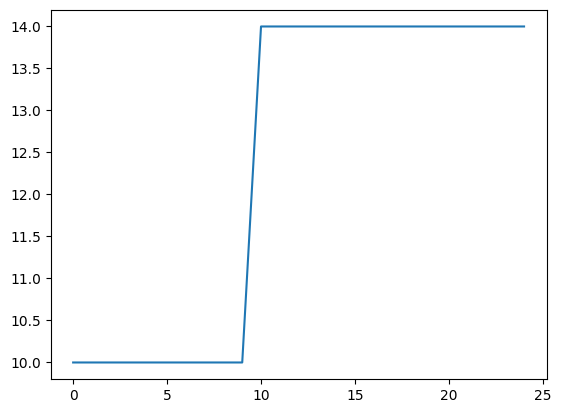

In [2]:
#r_vals = np.arange(14, 15, 1, dtype=np.float32)
r_vals = [10.0, 14.0]
def rho(t, r_vals = r_vals, step = 10):
    if t < step:
        return r_vals[0]
    elif t >= step:
        return r_vals[1]

plt.plot([rho(t) for t in range(0, 25)])

In [3]:
lorenz = ds.Lorenz(rho = rho)

#Generating data from Lorenz System with fixed parameters
dt = 0.05
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]
time_spans = [(0, 15)]
list = []

for t_span in time_spans:
    out = lorenz.solve(x0 = initial_conditions, t_span = t_span, dt = dt)
    list.append(np.expand_dims(out, axis=0))

data_full = np.concatenate(list, axis=0)
data_full.shape

(1, 300, 2, 3)

### Normalizing Data

In [4]:
norm = nodes.normalize_data(data_full.reshape(-1, 3))
data_norm = norm.normalize(data_full)

## Plotting 

In [5]:
data_norm.shape

(1, 300, 2, 3)

In [6]:
def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

    

In [7]:
data_norm[0, :, 0, 0].shape

(300,)

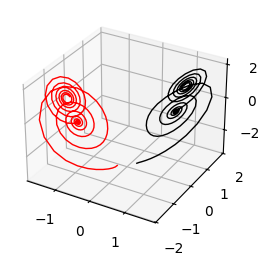

In [8]:

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
#ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
ax1.plot(xs=data_norm[0, :, 0, 0], ys=data_norm[0, :, 0, 1], zs=data_norm[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=data_norm[0, :, 1, 0], ys=data_norm[0, :, 1, 1], zs=data_norm[0, :, 1, 2], color = 'red', linewidth = 1)   



# Training Neural ODE

In [9]:
model = nodes.Piecewise_Auto_NODE(spatial_dim=3, depth=5, width = 30, time_range=[0, 15], num_breakpoints=1, activation_func=nn.Tanh())

In [12]:
model.break_params = torch.nn.Parameter(torch.tensor([10.0]), requires_grad=False)

In [13]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#Putting data into tensor 
#t_eval_tensor =  torch.tensor(np.arange(tstart, tfinal, dt))
training_data_tensor = torch.tensor(data_norm)

In [14]:
times = np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])
t_eval_tensor = torch.tensor(times)
t_eval_tensor.shape

torch.Size([1, 300])

## Single Loop 

In [15]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [16]:

t_eval_tensor.shape[1]

300

In [17]:
#Single training loop
optimizer.zero_grad()

pred_x_list = []
for i in range(t_eval_tensor.shape[0]):

    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
    pred_x_list.append(pred_x_temp)

pred_x = torch.stack(pred_x_list, dim=0)

loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(2.1248, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: None



In [18]:
optimizer.zero_grad()




pred_x = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_tensor[0, :].float(), method='rk4', options={'step_size': dt})


loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor[0, :, :, :].float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(1.6130, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: None



## Main Training Loop

In [19]:
def batch(data: torch.tensor, t: torch.tensor, batch_length: int, num_batch: int): # data shape (traj, dim, time) #All traj same length 
    '''
    Generates batches of data for training. 

    Input shape should be (time, traj, dim).

    Modifed to allow for multiple time spans

    Parameters:
    -----------       
    data : torch.tensor
        The full dataset from which to sample batches. (num_time_spans, time, traj, dim)

    t : torch.tensor
        The corresponding time tensor. (num_time_spans, time)
    '''
    data_length = data.shape[1]
    if batch_length >= data_length:
        raise ValueError("Batch length must be less than the length of the data.")
    else:
    #num_traj = data.shape[0]
        #traj_indices = np.random.randint(0, num_traj, batch_size)
        ic_indices = np.random.randint(0, data_length - batch_length, num_batch)

        batch_list = []
        batch_time_list = []

        for i in range(0, num_batch):
            batch_list.append(data[:, ic_indices[i]:ic_indices[i]+batch_length, :, :].float())
            batch_time_list.append(t[:, ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))
        
        #Each batch has shape (num_time_spans, batch_length, traj, dim) and each batch time has shape (num_time_spans, batch_length)

        return batch_list, batch_time_list

In [20]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [ ]:
batch_length = 20
num_batch = 15
num_epochs = 2000

for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
  
        pred_x_list = []
        for i in range(t_eval_tensor.shape[0]):
            pred_x_temp = odeint(model, batch_i[i, 0, :, :], batch_time_i[i, :], method='rk4', options={'step_size': dt})
            pred_x_list.append(pred_x_temp)

        pred_x = torch.stack(pred_x_list, dim=0)

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float()) 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()

    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x_list = []
                for i in range(t_eval_tensor.shape[0]):

                    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
                    pred_x_list.append(pred_x_temp)

                pred_x = torch.stack(pred_x_list, dim=0)
                
                train_loss = loss_fn(pred_x, training_data_tensor.float())
                loss_list.append(train_loss.item())


    if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {train_loss.item()}')
     
    
   

  0%|          | 1/2000 [00:03<1:49:49,  3.30s/it]

Epoch 0, Loss: 0.17780931293964386


  1%|          | 21/2000 [01:45<2:12:59,  4.03s/it]

Epoch 20, Loss: 0.14411112666130066


  2%|▏         | 41/2000 [03:33<3:15:13,  5.98s/it]

Epoch 40, Loss: 0.14519353210926056


  3%|▎         | 61/2000 [05:27<3:07:43,  5.81s/it]

Epoch 60, Loss: 0.12669029831886292


  4%|▍         | 81/2000 [07:18<3:04:23,  5.76s/it]

Epoch 80, Loss: 0.16811300814151764


  5%|▌         | 101/2000 [09:10<2:59:07,  5.66s/it]

Epoch 100, Loss: 0.16489918529987335


  6%|▌         | 121/2000 [11:04<3:00:47,  5.77s/it]

Epoch 120, Loss: 0.1539735198020935


  7%|▋         | 141/2000 [12:56<2:58:00,  5.75s/it]

Epoch 140, Loss: 0.14515548944473267


  8%|▊         | 161/2000 [14:29<1:42:15,  3.34s/it]

Epoch 160, Loss: 0.16211099922657013


  9%|▉         | 181/2000 [15:29<1:25:04,  2.81s/it]

Epoch 180, Loss: 0.13198508322238922


 10%|█         | 201/2000 [16:26<1:27:14,  2.91s/it]

Epoch 200, Loss: 0.1335248202085495


 11%|█         | 221/2000 [17:21<1:25:31,  2.88s/it]

Epoch 220, Loss: 0.1538383513689041


 12%|█▏        | 241/2000 [18:23<1:31:18,  3.11s/it]

Epoch 240, Loss: 0.17514178156852722


 13%|█▎        | 261/2000 [19:22<1:27:55,  3.03s/it]

Epoch 260, Loss: 0.18818306922912598


 14%|█▍        | 281/2000 [20:24<1:33:39,  3.27s/it]

Epoch 280, Loss: 0.14748576283454895


 15%|█▌        | 301/2000 [21:27<1:34:48,  3.35s/it]

Epoch 300, Loss: 0.131352037191391


 16%|█▌        | 321/2000 [22:31<1:28:29,  3.16s/it]

Epoch 320, Loss: 0.14673995971679688


 17%|█▋        | 341/2000 [23:35<1:33:10,  3.37s/it]

Epoch 340, Loss: 0.1601092517375946


 18%|█▊        | 361/2000 [24:39<1:28:37,  3.24s/it]

Epoch 360, Loss: 0.11870130896568298


 19%|█▉        | 381/2000 [25:42<1:28:10,  3.27s/it]

Epoch 380, Loss: 0.13452506065368652


 20%|██        | 401/2000 [26:45<1:26:24,  3.24s/it]

Epoch 400, Loss: 0.13306626677513123


 21%|██        | 421/2000 [27:49<1:26:31,  3.29s/it]

Epoch 420, Loss: 0.13402947783470154


 22%|██▏       | 441/2000 [28:55<1:26:39,  3.34s/it]

Epoch 440, Loss: 0.1989956647157669


 23%|██▎       | 461/2000 [30:00<1:26:29,  3.37s/it]

Epoch 460, Loss: 0.1330268830060959


 24%|██▍       | 481/2000 [31:05<1:23:58,  3.32s/it]

Epoch 480, Loss: 0.14501674473285675


 25%|██▌       | 501/2000 [32:08<1:16:13,  3.05s/it]

Epoch 500, Loss: 0.1684168428182602


 26%|██▌       | 521/2000 [33:15<1:22:50,  3.36s/it]

Epoch 520, Loss: 0.13537099957466125


 27%|██▋       | 541/2000 [34:19<1:17:36,  3.19s/it]

Epoch 540, Loss: 0.15384496748447418


 28%|██▊       | 561/2000 [35:23<1:19:14,  3.30s/it]

Epoch 560, Loss: 0.11662037670612335


 29%|██▉       | 581/2000 [36:28<1:20:08,  3.39s/it]

Epoch 580, Loss: 0.14150750637054443


 30%|███       | 601/2000 [37:33<1:19:48,  3.42s/it]

Epoch 600, Loss: 0.15822774171829224


 31%|███       | 621/2000 [38:35<1:14:37,  3.25s/it]

Epoch 620, Loss: 0.0981212705373764


 32%|███▏      | 641/2000 [39:39<1:15:43,  3.34s/it]

Epoch 640, Loss: 0.18930596113204956


 33%|███▎      | 661/2000 [40:45<1:12:24,  3.24s/it]

Epoch 660, Loss: 0.1426175981760025


 34%|███▍      | 681/2000 [41:48<1:11:09,  3.24s/it]

Epoch 680, Loss: 0.11224459111690521


 35%|███▌      | 701/2000 [42:50<1:06:14,  3.06s/it]

Epoch 700, Loss: 0.13072749972343445


 36%|███▌      | 721/2000 [43:48<1:03:47,  2.99s/it]

Epoch 720, Loss: 0.15725193917751312


 37%|███▋      | 741/2000 [44:45<1:02:34,  2.98s/it]

Epoch 740, Loss: 0.761053740978241


 38%|███▊      | 761/2000 [45:44<1:04:08,  3.11s/it]

Epoch 760, Loss: 0.7702277302742004


 39%|███▉      | 781/2000 [46:45<1:03:54,  3.15s/it]

Epoch 780, Loss: 0.7972464561462402


 40%|████      | 801/2000 [47:47<1:04:00,  3.20s/it]

Epoch 800, Loss: 0.7842022180557251


 41%|████      | 821/2000 [48:48<1:00:02,  3.06s/it]

Epoch 820, Loss: 0.7653948068618774


 42%|████▏     | 841/2000 [49:46<57:46,  2.99s/it]  

Epoch 840, Loss: 0.7240303158760071


 43%|████▎     | 861/2000 [50:43<56:13,  2.96s/it]

Epoch 860, Loss: 0.7846085429191589


 44%|████▍     | 881/2000 [51:41<58:14,  3.12s/it]

Epoch 880, Loss: 0.7690719962120056


 45%|████▌     | 901/2000 [52:38<54:38,  2.98s/it]

Epoch 900, Loss: 0.7329210042953491


 46%|████▌     | 921/2000 [53:35<54:19,  3.02s/it]

Epoch 920, Loss: 0.7611803412437439


 47%|████▋     | 941/2000 [54:32<51:06,  2.90s/it]

Epoch 940, Loss: 0.23072679340839386


 48%|████▊     | 961/2000 [55:29<51:12,  2.96s/it]

Epoch 960, Loss: 0.152359277009964


 49%|████▉     | 981/2000 [56:27<50:56,  3.00s/it]

Epoch 980, Loss: 0.13635124266147614


 50%|█████     | 1001/2000 [57:24<49:22,  2.97s/it]

Epoch 1000, Loss: 0.729363203048706


 51%|█████     | 1021/2000 [58:21<47:24,  2.91s/it]

Epoch 1020, Loss: 0.7304211854934692


 52%|█████▏    | 1041/2000 [59:16<44:39,  2.79s/it]

Epoch 1040, Loss: 0.7360937595367432


 53%|█████▎    | 1061/2000 [1:00:12<45:12,  2.89s/it]

Epoch 1060, Loss: 0.7309211492538452


 54%|█████▍    | 1081/2000 [1:01:07<43:24,  2.83s/it]

Epoch 1080, Loss: 0.7228204607963562


 55%|█████▌    | 1101/2000 [1:02:04<44:45,  2.99s/it]

Epoch 1100, Loss: 0.7290984392166138


 56%|█████▌    | 1121/2000 [1:02:59<40:50,  2.79s/it]

Epoch 1120, Loss: 0.7431715130805969


 57%|█████▋    | 1141/2000 [1:03:56<44:22,  3.10s/it]

Epoch 1140, Loss: 0.7571859955787659


 58%|█████▊    | 1161/2000 [1:04:57<42:46,  3.06s/it]

Epoch 1160, Loss: 0.7730059027671814


 59%|█████▉    | 1181/2000 [1:05:57<42:07,  3.09s/it]

Epoch 1180, Loss: 0.7603493332862854


 60%|██████    | 1201/2000 [1:07:06<47:33,  3.57s/it]

Epoch 1200, Loss: 0.7323864102363586


 61%|██████    | 1221/2000 [1:08:14<46:02,  3.55s/it]

Epoch 1220, Loss: 0.7568385004997253


 62%|██████▏   | 1241/2000 [1:09:23<45:41,  3.61s/it]

Epoch 1240, Loss: 0.7555400729179382


 63%|██████▎   | 1261/2000 [1:10:33<44:35,  3.62s/it]

Epoch 1260, Loss: 0.7251591682434082


 64%|██████▍   | 1281/2000 [1:11:44<44:21,  3.70s/it]

Epoch 1280, Loss: 0.7456003427505493


 65%|██████▌   | 1301/2000 [1:12:54<40:58,  3.52s/it]

Epoch 1300, Loss: 0.7192422151565552


 66%|██████▌   | 1321/2000 [1:14:04<41:15,  3.65s/it]

Epoch 1320, Loss: 0.7362643480300903


 67%|██████▋   | 1341/2000 [1:15:14<39:41,  3.61s/it]

Epoch 1340, Loss: 0.7654598951339722


 68%|██████▊   | 1361/2000 [1:16:28<40:26,  3.80s/it]

Epoch 1360, Loss: 0.7320215106010437


 69%|██████▉   | 1381/2000 [1:17:44<39:48,  3.86s/it]

Epoch 1380, Loss: 0.753509521484375


 70%|███████   | 1401/2000 [1:18:56<38:03,  3.81s/it]

Epoch 1400, Loss: 0.7623275518417358


 71%|███████   | 1421/2000 [1:20:06<33:10,  3.44s/it]

Epoch 1420, Loss: 0.7770558595657349


 72%|███████▏  | 1441/2000 [1:21:13<31:54,  3.42s/it]

Epoch 1440, Loss: 0.13857901096343994


 73%|███████▎  | 1461/2000 [1:22:20<31:06,  3.46s/it]

Epoch 1460, Loss: 0.17436477541923523


 74%|███████▍  | 1481/2000 [1:23:27<30:35,  3.54s/it]

Epoch 1480, Loss: 0.7528855800628662


 75%|███████▌  | 1501/2000 [1:24:34<29:00,  3.49s/it]

Epoch 1500, Loss: 0.8169810771942139


 76%|███████▌  | 1521/2000 [1:25:40<27:07,  3.40s/it]

Epoch 1520, Loss: 0.7437871694564819


 77%|███████▋  | 1541/2000 [1:26:45<26:02,  3.40s/it]

Epoch 1540, Loss: 0.7389823794364929


 78%|███████▊  | 1561/2000 [1:27:51<24:28,  3.34s/it]

Epoch 1560, Loss: 0.7579026222229004


 79%|███████▉  | 1581/2000 [1:28:56<23:36,  3.38s/it]

Epoch 1580, Loss: 0.904785692691803


 80%|████████  | 1601/2000 [1:30:02<22:35,  3.40s/it]

Epoch 1600, Loss: 1.0432566404342651


 81%|████████  | 1621/2000 [1:31:09<21:18,  3.37s/it]

Epoch 1620, Loss: 0.9411259889602661


 82%|████████▏ | 1641/2000 [1:32:19<20:44,  3.47s/it]

Epoch 1640, Loss: 0.9217211008071899


 83%|████████▎ | 1661/2000 [1:33:27<21:04,  3.73s/it]

Epoch 1660, Loss: 0.8772596120834351


 84%|████████▍ | 1681/2000 [1:34:40<20:07,  3.78s/it]

Epoch 1680, Loss: 0.8605377078056335


 85%|████████▌ | 1701/2000 [1:35:49<16:49,  3.38s/it]

Epoch 1700, Loss: 0.37809693813323975


 86%|████████▌ | 1721/2000 [1:36:55<16:01,  3.45s/it]

Epoch 1720, Loss: 0.470742404460907


 87%|████████▋ | 1741/2000 [1:38:03<15:02,  3.49s/it]

Epoch 1740, Loss: 0.31753620505332947


 88%|████████▊ | 1761/2000 [1:39:09<13:45,  3.45s/it]

Epoch 1760, Loss: 0.31700384616851807


 89%|████████▉ | 1781/2000 [1:40:14<12:14,  3.35s/it]

Epoch 1780, Loss: 0.3183425962924957


 90%|█████████ | 1801/2000 [1:41:20<11:24,  3.44s/it]

Epoch 1800, Loss: 0.26269474625587463


 91%|█████████ | 1821/2000 [1:42:26<09:57,  3.34s/it]

Epoch 1820, Loss: 0.2286505252122879


 92%|█████████▏| 1841/2000 [1:43:32<09:01,  3.40s/it]

Epoch 1840, Loss: 0.2121528685092926


 93%|█████████▎| 1861/2000 [1:44:38<07:46,  3.36s/it]

Epoch 1860, Loss: 0.7850082516670227


 94%|█████████▍| 1881/2000 [1:45:42<06:16,  3.16s/it]

Epoch 1880, Loss: 0.25002118945121765


 95%|█████████▌| 1901/2000 [1:46:44<05:12,  3.16s/it]

Epoch 1900, Loss: 0.18417102098464966


 96%|█████████▌| 1921/2000 [1:47:47<04:14,  3.22s/it]

Epoch 1920, Loss: 0.20835764706134796


 97%|█████████▋| 1941/2000 [1:48:49<03:06,  3.16s/it]

Epoch 1940, Loss: 0.4008157551288605


 98%|█████████▊| 1961/2000 [1:49:50<02:02,  3.15s/it]

Epoch 1960, Loss: 0.45448505878448486


 99%|█████████▉| 1981/2000 [1:50:52<00:59,  3.13s/it]

Epoch 1980, Loss: 0.3062763810157776


100%|██████████| 2000/2000 [1:51:51<00:00,  3.36s/it]


: 

In [22]:
model.break_params

Parameter containing:
tensor([10.])

## Plotting results

In [27]:
loss_list_v3 = np.loadtxt('Data/PA_NODE_Bif_Lorenz-v3_Loss.csv')

In [32]:
np.savetxt('Data/PA_NODE_Bif_Lorenz-v6_Loss.csv', loss_list)

Text(0.5, 0, 'Epochs')

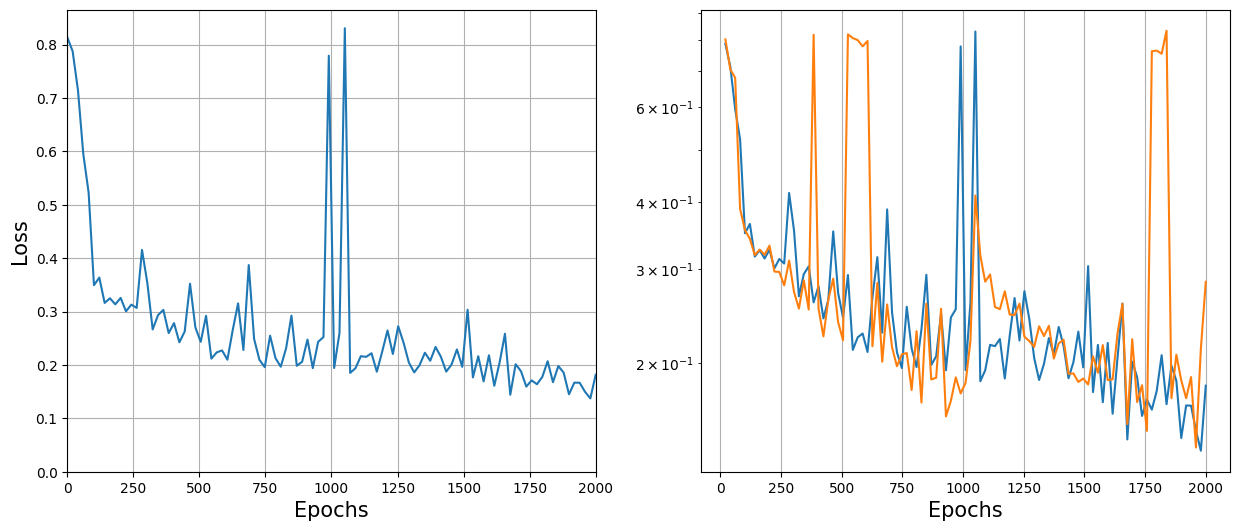

In [31]:
### Analysis  
epochs = len(loss_list)*20
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
ax2.plot(e_pts[1:], loss_list_v3[1:100], linestyle='-')
#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [24]:
t_Start_pred = 0; t_Final_pred = 30
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})

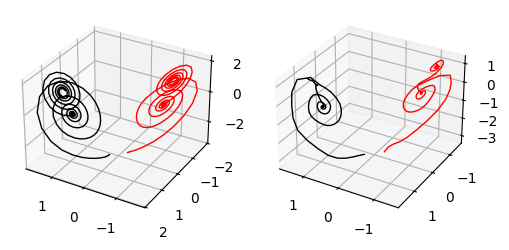

In [25]:
#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[0, :, 0, 0], ys=training_data_tensor[0, :, 0, 1], zs=training_data_tensor[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[0, :, 1, 0], ys=training_data_tensor[0, :, 1, 1], zs=training_data_tensor[0, :, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0, 0].detach().numpy(), ys=node_data[:, 0, 1].detach().numpy(), zs=node_data[:, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
ax2.plot(xs=node_data[:, 1, 0].detach().numpy(), ys=node_data[:, 1, 1].detach().numpy(), zs=node_data[:, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

ax2.view_init(elev = 30, azim = 120)

plt.show()

In [67]:

def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[0, :index, 0, 0], ys=data_norm[0, :index, 0, 1], zs=data_norm[0, :index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[0, :index, 1, 0], ys=data_norm[0, :index, 1, 1], zs=data_norm[0, :index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

In [68]:
def plot_interact2(index):
        #Plotting results
        fig = plt.figure(figsize=(6, 8))

        #First Plot
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot(xs=training_data_tensor[0, :index, 0, 0], ys=training_data_tensor[0, :index, 0, 1], zs=training_data_tensor[0, :index, 0, 2], color = 'black', linewidth = 1 )
        ax1.plot(xs=training_data_tensor[0, :index, 1, 0], ys=training_data_tensor[0, :index, 1, 1], zs=training_data_tensor[0, :index, 1, 2], color = 'red', linewidth = 1 )

        #ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
        ax1.view_init(elev = 30, azim = 120)


        #Second Plot 
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.plot(xs=node_data[:index, 0, 0].detach().numpy(), ys=node_data[:index, 0, 1].detach().numpy(), zs=node_data[:index, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
        ax2.plot(xs=node_data[:index, 1, 0].detach().numpy(), ys=node_data[:index, 1, 1].detach().numpy(), zs=node_data[:index, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

        ax2.view_init(elev = 30, azim = 120)



In [26]:
node_data.shape

torch.Size([300, 2, 3])

In [27]:
model.break_params

Parameter containing:
tensor([7.5526], requires_grad=True)

In [90]:

interact(plot_interact2, index=IntSlider(min=0, max=500, step=1))

interactive(children=(IntSlider(value=0, description='index', max=500), Output()), _dom_classes=('widget-inter…

<function __main__.plot_interact2(index)>

## Bifurcation Diagram

In [29]:
a = 1

In [30]:
np.vectorize(lorenz.f)

In [31]:
integ.solve_ivp(fun = np.vectorize(lorenz.f), t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', 
                t_eval = np.arange(t_Start, t_Final, dt), )




NameError: name 't_Start' is not defined

In [ ]:
r_eval = np.arange(0, 28, 0.1)
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]

t_Start = 0; t_Final = 250; t_Transient = 230; dt = 0.01

In [ ]:
x_list = []
r_list = []
for r in tqdm(r_eval):
    lorenz.rho = lambda t: r
    
    for y0 in initial_conditions:
        output = integ.solve_ivp(fun = lorenz.f, t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', t_eval = np.arange(t_Start, t_Final, dt))
        z_plane = r-1
        z = output.y[2, int(t_Transient/dt):]

        #Where does do we cross the plane z = r-1 from below 
        
        indices = np.where((z[:-1] - z_plane)*(z[1:] - z_plane) <= 0)[0]
        for idx in indices:
            x_pts = output.y[0, int(t_Transient/dt):][idx]
            r_list.append(r)
            x_list.append(x_pts)
      



100%|██████████| 280/280 [02:05<00:00,  2.24it/s]
